# Generative Adversarial Network(GAN)


https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [4]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    x_train = x_train[0:100,:]
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(100, 784)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [6]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dens

In [7]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___________________________

In [8]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=4, dim=(2,2), figsize=(5,5)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
import time
import numpy as np
from IPython.display import SVG, display
from PIL import Image

def invert_image(img):
    return( np.invert(img)  )

  
def denomalize_image(img, invert=False):
    if img.dtype is np.dtype(np.float32):
      image = img * 255
      image = image.astype('uint8')
    else:
      image = img
    
    if invert == True:
      image = invert_image( image )

    return( image )
    

def init_display(img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out = display(img_disp, display_id=True)
    else:
      out = display(img_disp.resize((width*zoom,height*zoom)), display_id=True)
    return( out )


def update_display(out, img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out.update(img_disp)
    else:
      out.update(img_disp.resize((width*zoom,height*zoom)))

    

In [0]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    
    display_output = init_display(np.concatenate(X_train[0:batch_size].reshape(batch_size,28,28),axis = 1))

    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 5 == 0:
            #plot_generated_images(e, generator)
            update_display(display_output, np.concatenate( generated_images[0:batch_size].reshape(batch_size,28,28),axis = 1) )


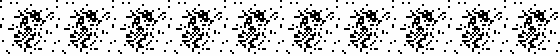

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


 20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 2


 20%|██        | 2/10 [00:00<00:00, 16.45it/s]

Epoch 3


 20%|██        | 2/10 [00:00<00:00, 16.37it/s]

Epoch 4


 20%|██        | 2/10 [00:00<00:00, 17.36it/s]

Epoch 5


 20%|██        | 2/10 [00:00<00:00, 15.54it/s]

Epoch 6


 20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 7


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 8


 20%|██        | 2/10 [00:00<00:00, 16.74it/s]

Epoch 9


 20%|██        | 2/10 [00:00<00:00, 14.59it/s]

Epoch 10


 20%|██        | 2/10 [00:00<00:00, 16.14it/s]

Epoch 11


 20%|██        | 2/10 [00:00<00:00, 16.37it/s]

Epoch 12


 20%|██        | 2/10 [00:00<00:00, 16.37it/s]

Epoch 13


 20%|██        | 2/10 [00:00<00:00, 16.79it/s]

Epoch 14


 20%|██        | 2/10 [00:00<00:00, 17.17it/s]

Epoch 15


 20%|██        | 2/10 [00:00<00:00, 15.30it/s]

Epoch 16


 20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 17


 20%|██        | 2/10 [00:00<00:00, 17.48it/s]

Epoch 18


 20%|██        | 2/10 [00:00<00:00, 16.98it/s]

Epoch 19


 20%|██        | 2/10 [00:00<00:00, 16.25it/s]

Epoch 20


 20%|██        | 2/10 [00:00<00:00, 16.09it/s]

Epoch 21


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 22


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 23


 20%|██        | 2/10 [00:00<00:00, 17.25it/s]

Epoch 24


 20%|██        | 2/10 [00:00<00:00, 16.77it/s]

Epoch 25


 20%|██        | 2/10 [00:00<00:00, 16.97it/s]

Epoch 26


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 27


 20%|██        | 2/10 [00:00<00:00, 16.12it/s]

Epoch 28


 20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 29


 20%|██        | 2/10 [00:00<00:00, 17.67it/s]

Epoch 30


 20%|██        | 2/10 [00:00<00:00, 15.83it/s]

Epoch 31


 20%|██        | 2/10 [00:00<00:00, 17.05it/s]

Epoch 32


 20%|██        | 2/10 [00:00<00:00, 17.03it/s]

Epoch 33


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 34


 20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 35


 20%|██        | 2/10 [00:00<00:00, 16.11it/s]

Epoch 36


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 37


 20%|██        | 2/10 [00:00<00:00, 16.00it/s]

Epoch 38


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 39


 20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 40


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 41


 20%|██        | 2/10 [00:00<00:00, 17.07it/s]

Epoch 42


 20%|██        | 2/10 [00:00<00:00, 16.70it/s]

Epoch 43


 20%|██        | 2/10 [00:00<00:00, 14.94it/s]

Epoch 44


 20%|██        | 2/10 [00:00<00:00, 15.83it/s]

Epoch 45


 20%|██        | 2/10 [00:00<00:00, 15.59it/s]

Epoch 46


 20%|██        | 2/10 [00:00<00:00, 16.19it/s]

Epoch 47


 20%|██        | 2/10 [00:00<00:00, 16.00it/s]

Epoch 48


 20%|██        | 2/10 [00:00<00:00, 15.97it/s]

Epoch 49


 20%|██        | 2/10 [00:00<00:00, 15.63it/s]

Epoch 50


 20%|██        | 2/10 [00:00<00:00, 15.36it/s]

Epoch 51


 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

Epoch 52


 20%|██        | 2/10 [00:00<00:00, 15.80it/s]

Epoch 53


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 54


 20%|██        | 2/10 [00:00<00:00, 16.04it/s]

Epoch 55


 20%|██        | 2/10 [00:00<00:00, 16.39it/s]

Epoch 56


 20%|██        | 2/10 [00:00<00:00, 15.55it/s]

Epoch 57


 20%|██        | 2/10 [00:00<00:00, 16.28it/s]

Epoch 58


 20%|██        | 2/10 [00:00<00:00, 16.00it/s]

Epoch 59


 20%|██        | 2/10 [00:00<00:00, 15.14it/s]

Epoch 60


 20%|██        | 2/10 [00:00<00:00, 17.12it/s]

Epoch 61


 20%|██        | 2/10 [00:00<00:00, 16.74it/s]

Epoch 62


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 63


 20%|██        | 2/10 [00:00<00:00, 16.41it/s]

Epoch 64


 20%|██        | 2/10 [00:00<00:00, 16.17it/s]

Epoch 65


 20%|██        | 2/10 [00:00<00:00, 15.94it/s]

Epoch 66


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 67


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 68


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 69


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 70


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 71


 20%|██        | 2/10 [00:00<00:00, 16.43it/s]

Epoch 72


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 73


 20%|██        | 2/10 [00:00<00:00, 15.72it/s]

Epoch 74


 20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 75


 20%|██        | 2/10 [00:00<00:00, 14.29it/s]

Epoch 76


 20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 77


 20%|██        | 2/10 [00:00<00:00, 15.79it/s]

Epoch 78


 20%|██        | 2/10 [00:00<00:00, 17.30it/s]

Epoch 79


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 80


 20%|██        | 2/10 [00:00<00:00, 15.90it/s]

Epoch 81


 20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 82


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 83


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 84


 20%|██        | 2/10 [00:00<00:00, 16.39it/s]

Epoch 85


 20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 86


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 87


 20%|██        | 2/10 [00:00<00:00, 17.03it/s]

Epoch 88


 20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 89


 20%|██        | 2/10 [00:00<00:00, 15.85it/s]

Epoch 90


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 91


 20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 92


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 93


 20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 94


 20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 95


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 96


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 97


 20%|██        | 2/10 [00:00<00:00, 16.53it/s]

Epoch 98


 20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 99


 20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 100


 20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 101


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 102


 20%|██        | 2/10 [00:00<00:00, 16.13it/s]

Epoch 103


 20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 104


 20%|██        | 2/10 [00:00<00:00, 16.18it/s]

Epoch 105


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 106


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 107


 20%|██        | 2/10 [00:00<00:00, 16.02it/s]

Epoch 108


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 109


 20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 110


 20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 111


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 112


 20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 113


 20%|██        | 2/10 [00:00<00:00, 15.86it/s]

Epoch 114


 20%|██        | 2/10 [00:00<00:00, 16.45it/s]

Epoch 115


 20%|██        | 2/10 [00:00<00:00, 16.03it/s]

Epoch 116


 20%|██        | 2/10 [00:00<00:00, 16.74it/s]

Epoch 117


 20%|██        | 2/10 [00:00<00:00, 16.49it/s]

Epoch 118


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 119


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 120


 20%|██        | 2/10 [00:00<00:00, 15.47it/s]

Epoch 121


 20%|██        | 2/10 [00:00<00:00, 16.54it/s]

Epoch 122


 20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 123


 20%|██        | 2/10 [00:00<00:00, 16.34it/s]

Epoch 124


 20%|██        | 2/10 [00:00<00:00, 16.23it/s]

Epoch 125


 20%|██        | 2/10 [00:00<00:00, 13.04it/s]

Epoch 126


 20%|██        | 2/10 [00:00<00:00, 16.39it/s]

Epoch 127


 20%|██        | 2/10 [00:00<00:00, 16.64it/s]

Epoch 128


 20%|██        | 2/10 [00:00<00:00, 16.32it/s]

Epoch 129


 20%|██        | 2/10 [00:00<00:00, 17.08it/s]

Epoch 130


 20%|██        | 2/10 [00:00<00:00, 15.56it/s]

Epoch 131


 20%|██        | 2/10 [00:00<00:00, 16.97it/s]

Epoch 132


 20%|██        | 2/10 [00:00<00:00, 17.10it/s]

Epoch 133


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 134


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 135


 20%|██        | 2/10 [00:00<00:00, 17.22it/s]

Epoch 136


 20%|██        | 2/10 [00:00<00:00, 16.91it/s]

Epoch 137


 20%|██        | 2/10 [00:00<00:00, 16.21it/s]

Epoch 138


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 139


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 140


 20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 141


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 142


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 143


 20%|██        | 2/10 [00:00<00:00, 16.99it/s]

Epoch 144


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 145


 20%|██        | 2/10 [00:00<00:00, 14.54it/s]

Epoch 146


 20%|██        | 2/10 [00:00<00:00, 16.38it/s]

Epoch 147


 20%|██        | 2/10 [00:00<00:00, 16.90it/s]

Epoch 148


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 149


 20%|██        | 2/10 [00:00<00:00, 17.19it/s]

Epoch 150


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 151


 20%|██        | 2/10 [00:00<00:00, 16.77it/s]

Epoch 152


 20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 153


 20%|██        | 2/10 [00:00<00:00, 17.16it/s]

Epoch 154


 20%|██        | 2/10 [00:00<00:00, 17.26it/s]

Epoch 155


 20%|██        | 2/10 [00:00<00:00, 15.97it/s]

Epoch 156


 20%|██        | 2/10 [00:00<00:00, 16.48it/s]

Epoch 157


 20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 158


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 159


 20%|██        | 2/10 [00:00<00:00, 17.17it/s]

Epoch 160


 20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 161


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 162


 20%|██        | 2/10 [00:00<00:00, 16.64it/s]

Epoch 163


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 164


 20%|██        | 2/10 [00:00<00:00, 16.26it/s]

Epoch 165


 20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 166


 20%|██        | 2/10 [00:00<00:00, 16.46it/s]

Epoch 167


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 168


 20%|██        | 2/10 [00:00<00:00, 16.41it/s]

Epoch 169


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 170


 20%|██        | 2/10 [00:00<00:00, 15.60it/s]

Epoch 171


 20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 172


 20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 173


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 174


 20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 175


 20%|██        | 2/10 [00:00<00:00, 16.78it/s]

Epoch 176


 20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 177


 20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 178


 20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 179


 20%|██        | 2/10 [00:00<00:00, 16.18it/s]

Epoch 180


 20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 181


 20%|██        | 2/10 [00:00<00:00, 16.35it/s]

Epoch 182


 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

Epoch 183


 20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 184


 20%|██        | 2/10 [00:00<00:00, 16.26it/s]

Epoch 185


 20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 186


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 187


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 188


 20%|██        | 2/10 [00:00<00:00, 16.74it/s]

Epoch 189


 20%|██        | 2/10 [00:00<00:00, 15.79it/s]

Epoch 190


 20%|██        | 2/10 [00:00<00:00, 16.25it/s]

Epoch 191


 20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 192


 20%|██        | 2/10 [00:00<00:00, 14.28it/s]

Epoch 193


 20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 194


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 195


 20%|██        | 2/10 [00:00<00:00, 16.80it/s]

Epoch 196


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 197


 20%|██        | 2/10 [00:00<00:00, 16.34it/s]

Epoch 198


 20%|██        | 2/10 [00:00<00:00, 16.67it/s]

Epoch 199


 20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 200


 20%|██        | 2/10 [00:00<00:00, 16.32it/s]

Epoch 201


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 202


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 203


 20%|██        | 2/10 [00:00<00:00, 16.34it/s]

Epoch 204


 20%|██        | 2/10 [00:00<00:00, 16.97it/s]

Epoch 205


 20%|██        | 2/10 [00:00<00:00, 15.82it/s]

Epoch 206


 20%|██        | 2/10 [00:00<00:00, 16.29it/s]

Epoch 207


 20%|██        | 2/10 [00:00<00:00, 16.28it/s]

Epoch 208


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 209


 20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 210


 20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 211


 20%|██        | 2/10 [00:00<00:00, 15.98it/s]

Epoch 212


 20%|██        | 2/10 [00:00<00:00, 15.59it/s]

Epoch 213


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 214


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 215


 20%|██        | 2/10 [00:00<00:00, 16.28it/s]

Epoch 216


 20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 217


 20%|██        | 2/10 [00:00<00:00, 16.53it/s]

Epoch 218


 20%|██        | 2/10 [00:00<00:00, 17.19it/s]

Epoch 219


 20%|██        | 2/10 [00:00<00:00, 16.26it/s]

Epoch 220


 20%|██        | 2/10 [00:00<00:00, 14.98it/s]

Epoch 221


 20%|██        | 2/10 [00:00<00:00, 16.59it/s]

Epoch 222


 20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 223


 20%|██        | 2/10 [00:00<00:00, 16.84it/s]

Epoch 224


 20%|██        | 2/10 [00:00<00:00, 17.08it/s]

Epoch 225


 20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 226


 20%|██        | 2/10 [00:00<00:00, 16.41it/s]

Epoch 227


 20%|██        | 2/10 [00:00<00:00, 16.98it/s]

Epoch 228


 20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Epoch 229


 20%|██        | 2/10 [00:00<00:00, 16.10it/s]

Epoch 230


 20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 231


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 232


 20%|██        | 2/10 [00:00<00:00, 16.19it/s]

Epoch 233


 20%|██        | 2/10 [00:00<00:00, 16.90it/s]

Epoch 234


 20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 235


 20%|██        | 2/10 [00:00<00:00, 15.92it/s]

Epoch 236


 20%|██        | 2/10 [00:00<00:00, 16.76it/s]

Epoch 237


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 238


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 239


 20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 240


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 241


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 242


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 243


 20%|██        | 2/10 [00:00<00:00, 17.05it/s]

Epoch 244


 20%|██        | 2/10 [00:00<00:00, 16.99it/s]

Epoch 245


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 246


 20%|██        | 2/10 [00:00<00:00, 16.18it/s]

Epoch 247


 20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 248


 20%|██        | 2/10 [00:00<00:00, 17.13it/s]

Epoch 249


 20%|██        | 2/10 [00:00<00:00, 15.90it/s]

Epoch 250


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 251


 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

Epoch 252


 20%|██        | 2/10 [00:00<00:00, 16.48it/s]

Epoch 253


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 254


 20%|██        | 2/10 [00:00<00:00, 16.21it/s]

Epoch 255


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 256


 20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 257


 20%|██        | 2/10 [00:00<00:00, 17.03it/s]

Epoch 258


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 259


 20%|██        | 2/10 [00:00<00:00, 16.99it/s]

Epoch 260


 20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Epoch 261


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 262


 20%|██        | 2/10 [00:00<00:00, 16.79it/s]

Epoch 263


 20%|██        | 2/10 [00:00<00:00, 17.56it/s]

Epoch 264


 20%|██        | 2/10 [00:00<00:00, 16.56it/s]

Epoch 265


 20%|██        | 2/10 [00:00<00:00, 17.94it/s]

Epoch 266


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 267


 20%|██        | 2/10 [00:00<00:00, 16.99it/s]

Epoch 268


 20%|██        | 2/10 [00:00<00:00, 16.67it/s]

Epoch 269


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 270


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 271


 20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 272


 20%|██        | 2/10 [00:00<00:00, 16.46it/s]

Epoch 273


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 274


 20%|██        | 2/10 [00:00<00:00, 17.84it/s]

Epoch 275


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 276


 20%|██        | 2/10 [00:00<00:00, 17.39it/s]

Epoch 277


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 278


 20%|██        | 2/10 [00:00<00:00, 17.57it/s]

Epoch 279


 20%|██        | 2/10 [00:00<00:00, 16.95it/s]

Epoch 280


 20%|██        | 2/10 [00:00<00:00, 17.28it/s]

Epoch 281


 20%|██        | 2/10 [00:00<00:00, 17.09it/s]

Epoch 282


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 283


 20%|██        | 2/10 [00:00<00:00, 17.14it/s]

Epoch 284


 20%|██        | 2/10 [00:00<00:00, 17.39it/s]

Epoch 285


 20%|██        | 2/10 [00:00<00:00, 16.56it/s]

Epoch 286


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 287


 20%|██        | 2/10 [00:00<00:00, 16.67it/s]

Epoch 288


 20%|██        | 2/10 [00:00<00:00, 17.24it/s]

Epoch 289


 20%|██        | 2/10 [00:00<00:00, 16.94it/s]

Epoch 290


 20%|██        | 2/10 [00:00<00:00, 16.25it/s]

Epoch 291


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 292


 20%|██        | 2/10 [00:00<00:00, 17.18it/s]

Epoch 293


 20%|██        | 2/10 [00:00<00:00, 17.05it/s]

Epoch 294


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 295


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 296


 20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 297


 20%|██        | 2/10 [00:00<00:00, 17.22it/s]

Epoch 298


 20%|██        | 2/10 [00:00<00:00, 17.58it/s]

Epoch 299


 20%|██        | 2/10 [00:00<00:00, 16.77it/s]

Epoch 300


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 301


 20%|██        | 2/10 [00:00<00:00, 17.60it/s]

Epoch 302


 20%|██        | 2/10 [00:00<00:00, 16.32it/s]

Epoch 303


 20%|██        | 2/10 [00:00<00:00, 17.36it/s]

Epoch 304


 20%|██        | 2/10 [00:00<00:00, 17.38it/s]

Epoch 305


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 306


 20%|██        | 2/10 [00:00<00:00, 17.27it/s]

Epoch 307


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 308


 20%|██        | 2/10 [00:00<00:00, 16.29it/s]

Epoch 309


 20%|██        | 2/10 [00:00<00:00, 17.35it/s]

Epoch 310


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 311


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 312


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 313


 20%|██        | 2/10 [00:00<00:00, 17.10it/s]

Epoch 314


 20%|██        | 2/10 [00:00<00:00, 17.81it/s]

Epoch 315


 20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 316


 20%|██        | 2/10 [00:00<00:00, 16.77it/s]

Epoch 317


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 318


 20%|██        | 2/10 [00:00<00:00, 17.20it/s]

Epoch 319


 20%|██        | 2/10 [00:00<00:00, 15.88it/s]

Epoch 320


 20%|██        | 2/10 [00:00<00:00, 16.48it/s]

Epoch 321


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 322


 20%|██        | 2/10 [00:00<00:00, 17.19it/s]

Epoch 323


 20%|██        | 2/10 [00:00<00:00, 16.10it/s]

Epoch 324


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 325


 20%|██        | 2/10 [00:00<00:00, 16.38it/s]

Epoch 326


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 327


 20%|██        | 2/10 [00:00<00:00, 16.93it/s]

Epoch 328


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 329


 20%|██        | 2/10 [00:00<00:00, 17.28it/s]

Epoch 330


 20%|██        | 2/10 [00:00<00:00, 16.27it/s]

Epoch 331


 20%|██        | 2/10 [00:00<00:00, 16.47it/s]

Epoch 332


 20%|██        | 2/10 [00:00<00:00, 17.20it/s]

Epoch 333


 20%|██        | 2/10 [00:00<00:00, 17.15it/s]

Epoch 334


 20%|██        | 2/10 [00:00<00:00, 17.22it/s]

Epoch 335


 20%|██        | 2/10 [00:00<00:00, 17.59it/s]

Epoch 336


 20%|██        | 2/10 [00:00<00:00, 16.32it/s]

Epoch 337


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 338


 20%|██        | 2/10 [00:00<00:00, 17.12it/s]

Epoch 339


 20%|██        | 2/10 [00:00<00:00, 16.80it/s]

Epoch 340


 20%|██        | 2/10 [00:00<00:00, 16.83it/s]

Epoch 341


 20%|██        | 2/10 [00:00<00:00, 17.35it/s]

Epoch 342


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 343


 20%|██        | 2/10 [00:00<00:00, 17.37it/s]

Epoch 344


 20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 345


 20%|██        | 2/10 [00:00<00:00, 15.95it/s]

Epoch 346


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 347


 20%|██        | 2/10 [00:00<00:00, 17.07it/s]

Epoch 348


 20%|██        | 2/10 [00:00<00:00, 17.20it/s]

Epoch 349


 20%|██        | 2/10 [00:00<00:00, 17.12it/s]

Epoch 350


 20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 351


 20%|██        | 2/10 [00:00<00:00, 17.08it/s]

Epoch 352


 20%|██        | 2/10 [00:00<00:00, 17.16it/s]

Epoch 353


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 354


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 355


 20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 356


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 357


 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 358


 20%|██        | 2/10 [00:00<00:00, 16.94it/s]

Epoch 359


 20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 360


 20%|██        | 2/10 [00:00<00:00, 17.15it/s]

Epoch 361


 20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 362


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 363


 20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 364


 20%|██        | 2/10 [00:00<00:00, 16.87it/s]

Epoch 365


 20%|██        | 2/10 [00:00<00:00, 15.84it/s]

Epoch 366


 20%|██        | 2/10 [00:00<00:00, 16.96it/s]

Epoch 367


 20%|██        | 2/10 [00:00<00:00, 17.04it/s]

Epoch 368


 20%|██        | 2/10 [00:00<00:00, 17.52it/s]

Epoch 369


 20%|██        | 2/10 [00:00<00:00, 17.14it/s]

Epoch 370


 20%|██        | 2/10 [00:00<00:00, 16.86it/s]

Epoch 371


 20%|██        | 2/10 [00:00<00:00, 17.11it/s]

Epoch 372


 20%|██        | 2/10 [00:00<00:00, 17.16it/s]

Epoch 373


 20%|██        | 2/10 [00:00<00:00, 16.64it/s]

Epoch 374


 20%|██        | 2/10 [00:00<00:00, 17.47it/s]

Epoch 375


 20%|██        | 2/10 [00:00<00:00, 17.13it/s]

Epoch 376


 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

Epoch 377


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 378


 20%|██        | 2/10 [00:00<00:00, 16.53it/s]

Epoch 379


 20%|██        | 2/10 [00:00<00:00, 17.43it/s]

Epoch 380


 20%|██        | 2/10 [00:00<00:00, 16.04it/s]

Epoch 381


 20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 382


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 383


 20%|██        | 2/10 [00:00<00:00, 16.83it/s]

Epoch 384


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 385


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 386


 20%|██        | 2/10 [00:00<00:00, 16.95it/s]

Epoch 387


 20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 388


 20%|██        | 2/10 [00:00<00:00, 17.06it/s]

Epoch 389


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 390


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 391


 20%|██        | 2/10 [00:00<00:00, 17.21it/s]

Epoch 392


 20%|██        | 2/10 [00:00<00:00, 17.35it/s]

Epoch 393


 20%|██        | 2/10 [00:00<00:00, 16.93it/s]

Epoch 394


 20%|██        | 2/10 [00:00<00:00, 16.92it/s]

Epoch 395


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 396


 20%|██        | 2/10 [00:00<00:00, 17.09it/s]

Epoch 397


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

Epoch 398


 20%|██        | 2/10 [00:00<00:00, 17.43it/s]

Epoch 399


 20%|██        | 2/10 [00:00<00:00, 17.24it/s]

Epoch 400


 20%|██        | 2/10 [00:00<00:00, 17.30it/s]

Epoch 401


 20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Epoch 402


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 403


 20%|██        | 2/10 [00:00<00:00, 17.77it/s]

Epoch 404


 20%|██        | 2/10 [00:00<00:00, 17.26it/s]

Epoch 405


 20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 406


 20%|██        | 2/10 [00:00<00:00, 17.61it/s]

Epoch 407


 20%|██        | 2/10 [00:00<00:00, 17.63it/s]

Epoch 408


 20%|██        | 2/10 [00:00<00:00, 17.63it/s]

Epoch 409


 20%|██        | 2/10 [00:00<00:00, 16.83it/s]

Epoch 410


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 411


 20%|██        | 2/10 [00:00<00:00, 16.67it/s]

Epoch 412


 20%|██        | 2/10 [00:00<00:00, 17.54it/s]

Epoch 413


 20%|██        | 2/10 [00:00<00:00, 17.44it/s]

Epoch 414


 20%|██        | 2/10 [00:00<00:00, 17.37it/s]

Epoch 415


 20%|██        | 2/10 [00:00<00:00, 16.81it/s]

Epoch 416


 20%|██        | 2/10 [00:00<00:00, 17.12it/s]

Epoch 417


 20%|██        | 2/10 [00:00<00:00, 17.21it/s]

Epoch 418


 20%|██        | 2/10 [00:00<00:00, 17.34it/s]

Epoch 419


 20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 420


 20%|██        | 2/10 [00:00<00:00, 16.96it/s]

Epoch 421


 20%|██        | 2/10 [00:00<00:00, 16.89it/s]

Epoch 422


 20%|██        | 2/10 [00:00<00:00, 17.51it/s]

Epoch 423


 20%|██        | 2/10 [00:00<00:00, 16.94it/s]

Epoch 424


 20%|██        | 2/10 [00:00<00:00, 17.26it/s]

Epoch 425


 20%|██        | 2/10 [00:00<00:00, 16.47it/s]

Epoch 426


 20%|██        | 2/10 [00:00<00:00, 17.62it/s]

Epoch 427


 20%|██        | 2/10 [00:00<00:00, 17.10it/s]

Epoch 428


 20%|██        | 2/10 [00:00<00:00, 16.40it/s]

Epoch 429


 20%|██        | 2/10 [00:00<00:00, 17.34it/s]

Epoch 430


 20%|██        | 2/10 [00:00<00:00, 17.80it/s]

Epoch 431


 20%|██        | 2/10 [00:00<00:00, 17.60it/s]

Epoch 432


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 433


 20%|██        | 2/10 [00:00<00:00, 17.40it/s]

Epoch 434


 20%|██        | 2/10 [00:00<00:00, 17.67it/s]

Epoch 435


 20%|██        | 2/10 [00:00<00:00, 17.34it/s]

Epoch 436


 20%|██        | 2/10 [00:00<00:00, 17.12it/s]

Epoch 437


 20%|██        | 2/10 [00:00<00:00, 17.19it/s]

Epoch 438


 20%|██        | 2/10 [00:00<00:00, 17.21it/s]

Epoch 439


 20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 440


 20%|██        | 2/10 [00:00<00:00, 17.39it/s]

Epoch 441


 20%|██        | 2/10 [00:00<00:00, 17.75it/s]

Epoch 442


 20%|██        | 2/10 [00:00<00:00, 17.54it/s]

Epoch 443


 20%|██        | 2/10 [00:00<00:00, 17.07it/s]

Epoch 444


 20%|██        | 2/10 [00:00<00:00, 17.79it/s]

Epoch 445


 20%|██        | 2/10 [00:00<00:00, 17.39it/s]

Epoch 446


 20%|██        | 2/10 [00:00<00:00, 17.03it/s]

Epoch 447


 20%|██        | 2/10 [00:00<00:00, 17.37it/s]

Epoch 448


 20%|██        | 2/10 [00:00<00:00, 17.78it/s]

Epoch 449


 20%|██        | 2/10 [00:00<00:00, 17.18it/s]

Epoch 450


 20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 451


 20%|██        | 2/10 [00:00<00:00, 17.06it/s]

Epoch 452


 20%|██        | 2/10 [00:00<00:00, 17.09it/s]

Epoch 453


 20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 454


 20%|██        | 2/10 [00:00<00:00, 16.95it/s]

Epoch 455


 20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 456


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 457


 20%|██        | 2/10 [00:00<00:00, 17.89it/s]

Epoch 458


 20%|██        | 2/10 [00:00<00:00, 17.45it/s]

Epoch 459


 20%|██        | 2/10 [00:00<00:00, 17.54it/s]

Epoch 460


 20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 461


 20%|██        | 2/10 [00:00<00:00, 17.52it/s]

Epoch 462


 20%|██        | 2/10 [00:00<00:00, 16.88it/s]

Epoch 463


 20%|██        | 2/10 [00:00<00:00, 17.05it/s]

Epoch 464


 20%|██        | 2/10 [00:00<00:00, 17.22it/s]

Epoch 465


 20%|██        | 2/10 [00:00<00:00, 17.15it/s]

Epoch 466


 20%|██        | 2/10 [00:00<00:00, 14.00it/s]

Epoch 467


 20%|██        | 2/10 [00:00<00:00, 17.65it/s]

Epoch 468


 20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 469


 20%|██        | 2/10 [00:00<00:00, 17.44it/s]

Epoch 470


 20%|██        | 2/10 [00:00<00:00, 16.91it/s]

Epoch 471


 20%|██        | 2/10 [00:00<00:00, 17.55it/s]

Epoch 472


 20%|██        | 2/10 [00:00<00:00, 17.51it/s]

Epoch 473


 20%|██        | 2/10 [00:00<00:00, 17.86it/s]

Epoch 474


 20%|██        | 2/10 [00:00<00:00, 17.43it/s]

Epoch 475


 20%|██        | 2/10 [00:00<00:00, 17.95it/s]

Epoch 476


 20%|██        | 2/10 [00:00<00:00, 16.85it/s]

Epoch 477


 20%|██        | 2/10 [00:00<00:00, 17.72it/s]

Epoch 478


 20%|██        | 2/10 [00:00<00:00, 17.25it/s]

Epoch 479


 20%|██        | 2/10 [00:00<00:00, 17.59it/s]

Epoch 480


 20%|██        | 2/10 [00:00<00:00, 17.02it/s]

Epoch 481


 20%|██        | 2/10 [00:00<00:00, 17.01it/s]

Epoch 482


 20%|██        | 2/10 [00:00<00:00, 17.29it/s]

Epoch 483


 20%|██        | 2/10 [00:00<00:00, 17.62it/s]

Epoch 484


 20%|██        | 2/10 [00:00<00:00, 17.02it/s]

Epoch 485


 20%|██        | 2/10 [00:00<00:00, 17.66it/s]

Epoch 486


 20%|██        | 2/10 [00:00<00:00, 16.83it/s]

Epoch 487


 20%|██        | 2/10 [00:00<00:00, 17.34it/s]

Epoch 488


 20%|██        | 2/10 [00:00<00:00, 17.57it/s]

Epoch 489


 20%|██        | 2/10 [00:00<00:00, 17.47it/s]

Epoch 490


 20%|██        | 2/10 [00:00<00:00, 17.02it/s]

Epoch 491


 20%|██        | 2/10 [00:00<00:00, 17.81it/s]

Epoch 492


 20%|██        | 2/10 [00:00<00:00, 17.13it/s]

Epoch 493


 20%|██        | 2/10 [00:00<00:00, 17.36it/s]

Epoch 494


 20%|██        | 2/10 [00:00<00:00, 17.46it/s]

Epoch 495


 20%|██        | 2/10 [00:00<00:00, 17.55it/s]

Epoch 496


 20%|██        | 2/10 [00:00<00:00, 17.23it/s]

Epoch 497


 20%|██        | 2/10 [00:00<00:00, 16.47it/s]

Epoch 498


 20%|██        | 2/10 [00:00<00:00, 17.81it/s]

Epoch 499


 20%|██        | 2/10 [00:00<00:00, 17.34it/s]

Epoch 500


100%|██████████| 10/10 [00:00<00:00, 17.17it/s]


In [13]:
training(500,10)